In [1]:
import pandas
import matplotlib
import seaborn
import collections
import itertools
import igraph

import sys
sys.path.append('..')

from helpers import (ECOSYSTEMS, DATE_RANGE, load_graph, evolution_regression, evolution_linlog_regressions, 
                     savefig, x_index)

%matplotlib inline

matplotlib.rcParams['pdf.fonttype'] = matplotlib.rcParams['ps.fonttype'] = 42
seaborn.set_palette('Set1', n_colors=len(ECOSYSTEMS))
seaborn.set_style('whitegrid')

In [2]:
# Use a subset of dates to speed up the notebook. 
# THIS LINE SHOULD BE COMMENTED OUT IN PRODUCTION!
# DATE_RANGE = pandas.date_range(DATE_RANGE[0], DATE_RANGE[-1], freq='3MS')

FIG_SIZE = (8, 4)
FIG_SIZE_WIDE = (10, 4)
COLORS = {ecosystem: seaborn.color_palette()[i] for i, ecosystem in enumerate(ECOSYSTEMS)}
sub = lambda c, e: [c[x] for x in e]

In [3]:
graphs = collections.OrderedDict()

for ecosystem in ECOSYSTEMS:
    print(ecosystem, end=': ')
    graphs[ecosystem] = collections.OrderedDict()
    
    for date in DATE_RANGE: 
        print('.', end='')
        graphs[ecosystem][date] = load_graph(ecosystem, date)
    
    print()

cargo: .............................................................
cpan: .............................................................
cran: .............................................................
npm: .............................................................
nuget: .............................................................
packagist: .............................................................
rubygems: .............................................................


## Graph size

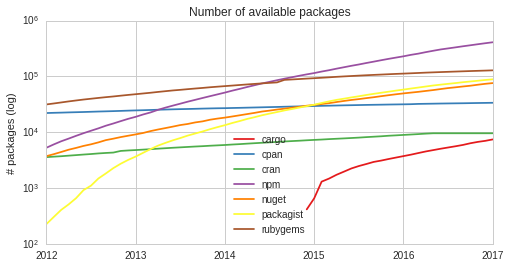

In [10]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = graph.vcount()
    
df.plot(ax=ax, logy=True, color=sub(COLORS, ECOSYSTEMS))
    
ax.set(
    xlabel='', 
    ylabel='# packages (log)',
    title='Number of available packages',
)

savefig(figure, 'graph_number_of_packages')

In [11]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.992577,0.998341,0.99312,0.878677,0.945816,0.929494,0.99475
lin-log,0.861659,0.991618,0.98505,0.983948,0.982103,0.903242,0.973238
log-lin,0.61026,0.646502,0.604388,0.390064,0.47421,0.43744,0.604362
log-log,0.88469,0.680449,0.688903,0.711395,0.718193,0.817622,0.713142


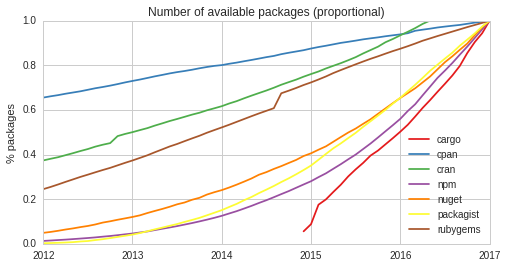

In [12]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue        
        df.loc[date, ecosystem] = graph.vcount() / graphs[ecosystem][DATE_RANGE[-1]].vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))
    
ax.set(
    xlabel='', 
    ylabel='% packages',
    title='Number of available packages (proportional)',
)

savefig(figure, 'graph_proportion_of_packages')

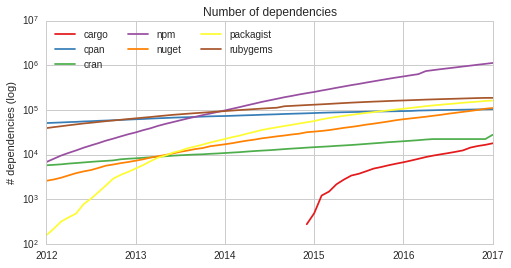

In [5]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue        
        df.loc[date, ecosystem] =  graph.ecount()
    
df.plot(ax=ax, logy=True, color=sub(COLORS, ECOSYSTEMS))
    
ax.set(
    xlabel='', 
    ylabel='# dependencies (log)',
    title='Number of dependencies',
)
ax.legend(loc='upper left', ncol=len(ECOSYSTEMS) // 2)
savefig(figure, 'graph_number_of_dependencies')

In [14]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.968174,0.997731,0.977673,0.833097,0.885422,0.926782,0.996761
lin-log,0.852518,0.98289,0.992064,0.984848,0.988464,0.87518,0.968479
log-lin,0.515419,0.643649,0.544589,0.349639,0.40371,0.430846,0.606653
log-log,0.878857,0.699342,0.664017,0.712498,0.702121,0.827576,0.728969


## Graph density

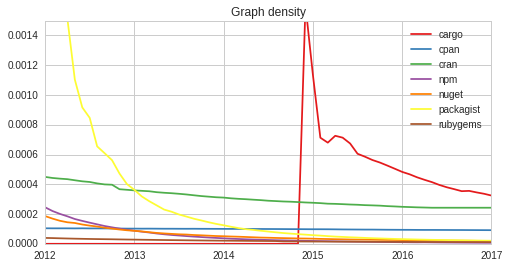

In [15]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        vs = graph.vcount()
        es = graph.ecount()
        df.loc[date, ecosystem] = (es) / (vs * (vs - 1)) if vs > 0 else 0
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))
    
ax.set(
    xlabel='', 
    ylabel='',
    title='Graph density',
    ylim=(0, 0.0015),
)

savefig(figure, 'graph_density')

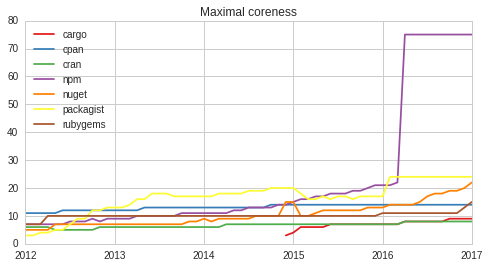

In [16]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        coreness = graph.coreness()
        df.loc[date, ecosystem] = pandas.np.max(coreness)
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Maximal coreness',
)

savefig(figure, 'graph_maximal_coreness')

## Clustering coefficient and average shortest path length

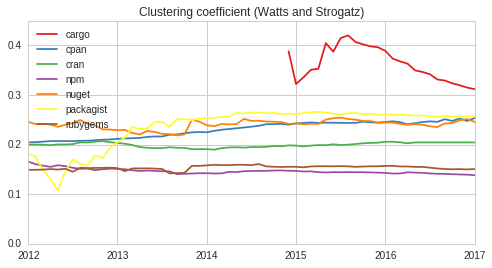

In [17]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        value = graph.transitivity_avglocal_undirected()
        # value = graph.transitivity_undirected()
        df.loc[date, ecosystem] = value
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Clustering coefficient (Watts and Strogatz)',
)
ax.set_ylim(bottom=0)

savefig(figure, 'graph_clustering_coefficient')

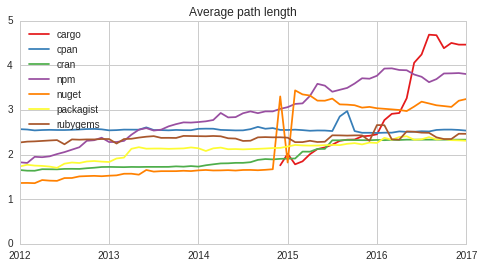

In [18]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        value = graph.average_path_length()
        df.loc[date, ecosystem] = value
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Average path length',
)
ax.set_ylim(bottom=0)

savefig(figure, 'graph_average_path_length')

**TODO** : 

https://en.wikipedia.org/wiki/Scale-free_network

https://arxiv.org/pdf/cs/0411096.pdf


## Distribution of dependencies

In [6]:
data = []
date = DATE_RANGE[-1]

for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    
    for node in graph.vs:
        if node['in'] + node['out'] == 0:
            continue
            
        data.append((
            ecosystem, 
            node['in'],
            node['out'],
            node['tr-in'],
            node['tr-out']
        ))
        
data = (
    pandas.DataFrame.from_records(
        data, 
        columns=['ecosystem', 'in', 'out', 'tr-in', 'tr-out']
    )
    .pipe(
        pandas.melt,
        id_vars='ecosystem', 
        value_vars=['in', 'out', 'tr-in', 'tr-out'], 
        var_name='kind'
    )
)

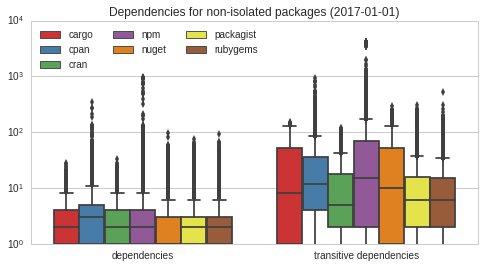

In [8]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

keep_kind = ['out', 'tr-out']

seaborn.boxplot(
    x='kind', 
    y='value', 
    hue='ecosystem',
    data=data[data['kind'].isin(keep_kind)],
    ax=ax,
    hue_order=ECOSYSTEMS,
    palette=COLORS
)

ax.set(
    xlabel='', 
    ylabel='',
    yscale='log',
    title='Dependencies for non-isolated packages ({})'.format(date.strftime('%Y-%m-%d')),
)

ax.legend(loc='upper left', ncol=len(ECOSYSTEMS) // 2)
ax.set_xticklabels(['dependencies', 'transitive dependencies'])

savefig(figure, 'graph_distribution_dependencies_non_isolated')

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


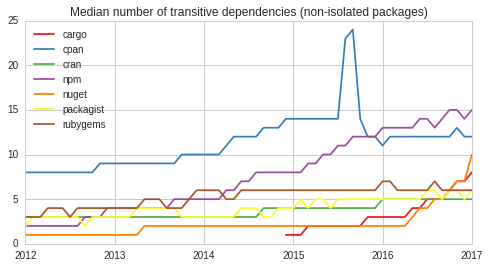

In [21]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = pandas.np.median(
            [v['tr-out'] for v in graph.vs if v['in'] + v['out'] > 0]
        )
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Median number of transitive dependencies (non-isolated packages)',
)

savefig(figure, 'graph_median_transitive_dependencies')

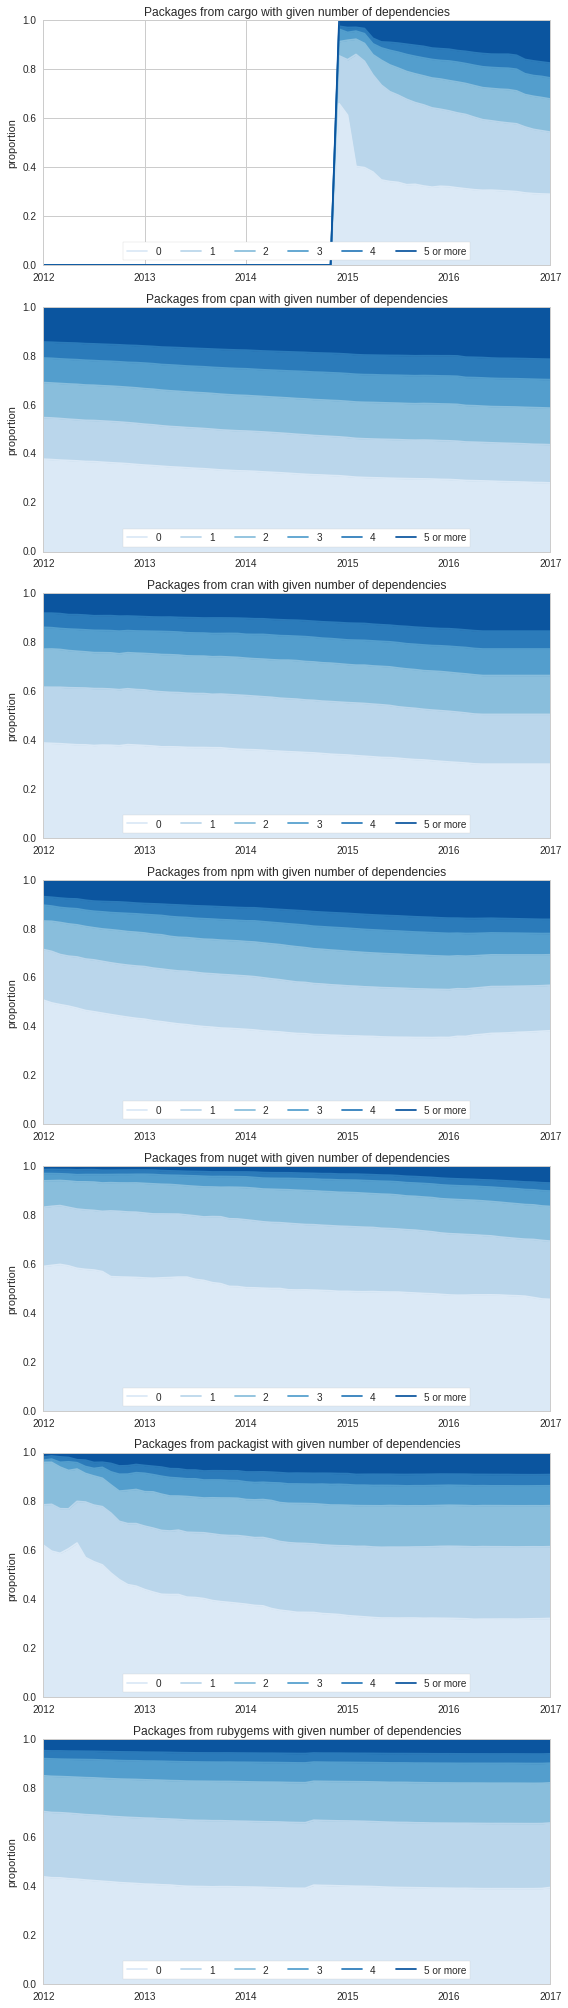

In [22]:
figure, axes = matplotlib.pyplot.subplots(nrows=len(ECOSYSTEMS))
figure.set_size_inches((FIG_SIZE[0], FIG_SIZE[1] * len(ECOSYSTEMS)))
        
bins = [0, 1, 2, 3, 4, 5, pandas.np.inf]
labels = ['0', '1', '2', '3', '4', '5 or more']
                       
for i, (ecosystem, dates) in enumerate(graphs.items()):
    ax = axes[i]
    df = pandas.DataFrame(index=DATE_RANGE, columns=labels)
    
    for date, graph in dates.items():
        counter = collections.Counter(
            pandas.cut(
                graph.vs['out'],
                bins=bins,
                labels=labels,
                right=False,
                include_lowest=True,
            )
        )
        for label in labels: 
            df.loc[date, label] = counter[label] / graph.vcount() if graph.vcount() > 0 else 0
    
    df.plot.area(ax=ax, color=seaborn.color_palette('Blues'))
    
    ax.set(
        xlabel='',
        ylabel='proportion',
        title='Packages from {} with given number of dependencies'.format(ecosystem),
        ylim=(0, 1)
    )
    
    ax.legend(
        ncol=len(labels),
        loc='lower center', 
        frameon=True,
    )

matplotlib.pyplot.tight_layout()

savefig(figure, 'graph_proportion_packages_with_number_of_dependencies')

## Isolated packages

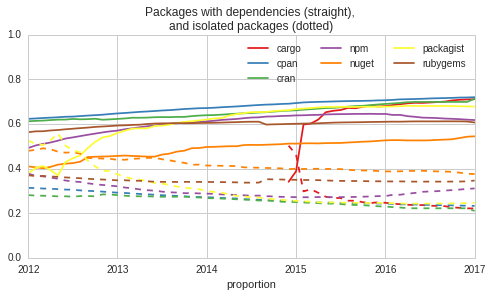

In [4]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df2 = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        with_deps = len(list(filter(lambda v: v['out'] > 0, graph.vs)))
        connected = len(list(filter(lambda v: v['in'] + v['out'] > 0, graph.vs)))
        
        try:
            df.loc[date, ecosystem] = with_deps / graph.vcount()
            df2.loc[date, ecosystem] = 1 - (connected / graph.vcount())
        except ZeroDivisionError:
            pass
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))
df2.plot(ax=ax, style='--', legend=False, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='proportion', 
    ylabel='',
    title='Packages with dependencies (straight), \nand isolated packages (dotted)',
    ylim=(0, 1),
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(ECOSYSTEMS)], labels[:len(ECOSYSTEMS)], ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_packages_with_dependencies_and_isolated')

In [23]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.492106,0.9804,0.973513,0.699452,0.90477,0.763674,0.684746
lin-log,0.424173,0.975564,0.977091,0.688931,0.885221,0.708271,0.67919
log-lin,0.879754,0.686115,0.532376,0.794925,0.740135,0.798424,0.80181
log-log,0.865745,0.696197,0.542876,0.812521,0.753918,0.806997,0.805842


In [24]:
evolution_linlog_regressions(df2.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.509547,0.97186,0.938711,0.437172,0.89668,0.770979,0.335545
lin-log,0.614423,0.981742,0.93157,0.429673,0.912612,0.83836,0.332518
log-lin,0.887762,0.698484,0.46049,0.677693,0.728777,0.767533,0.602032
log-log,0.899183,0.678113,0.447542,0.648143,0.717579,0.750351,0.593146


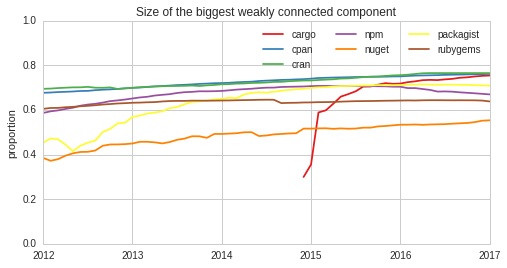

In [24]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        components = graph.components(mode=igraph.WEAK)
        df.loc[date, ecosystem] = components.giant().vcount() / graph.vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='proportion',
    title='Size of the biggest weakly connected component',
    ylim=(0, 1),
)
ax.legend(ncol=len(ECOSYSTEMS) //2 )

savefig(figure, 'graph_size_of_biggest_wcc')

In [25]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.492106,0.9804,0.973513,0.699452,0.90477,0.763674,0.684746
lin-log,0.424173,0.975564,0.977091,0.688931,0.885221,0.708271,0.67919
log-lin,0.879754,0.686115,0.532376,0.794925,0.740135,0.798424,0.80181
log-log,0.865745,0.696197,0.542876,0.812521,0.753918,0.806997,0.805842


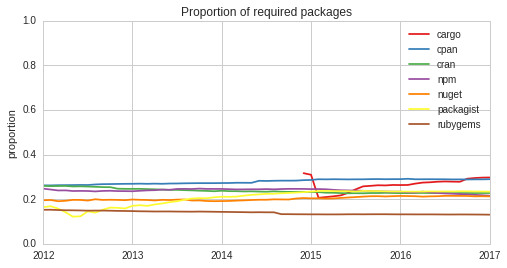

In [25]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        required = len([v for v in graph.vs if v['in'] > 0])
        df.loc[date, ecosystem] = required / graph.vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='proportion',
    title='Proportion of required packages',
    ylim=(0, 1),
)

savefig(figure, 'graph_proportion_required_packages')

## Bottom-level packages

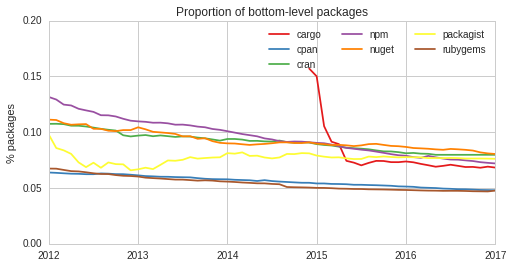

In [26]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = len(graph.vs.select(in_gt=0, out_eq=0)) / graph.vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='% packages', 
    title='Proportion of bottom-level packages',
    ylim=(0, 0.2)
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_proportion_bottom_level')

In [27]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.428618,0.995401,0.968652,0.982135,0.891107,0.0147085,0.943916
lin-log,0.492341,0.993607,0.974082,0.993449,0.905777,0.0255803,0.958573
log-lin,0.829915,0.605246,0.684172,0.726257,0.747826,0.0785584,0.741072
log-log,0.835471,0.58388,0.656025,0.670922,0.726677,0.0500869,0.713335


## Top-level packages
Top-level packages are packages that are not required but have at least one dependency.

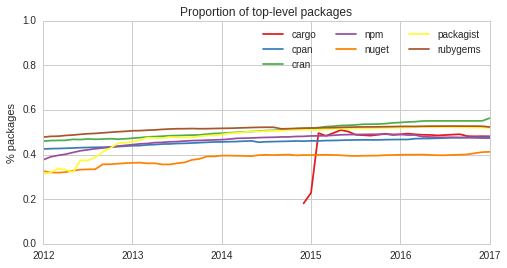

In [26]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = len(graph.vs.select(in_eq=0, out_gt=0)) / graph.vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='% packages', 
    title='Proportion of top-level packages',
    ylim=(0, 1)
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_proportion_top_level')

In [29]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.172964,0.949648,0.987452,0.683932,0.759347,0.688395,0.779998
lin-log,0.18497,0.944099,0.987705,0.669547,0.746085,0.638876,0.771391
log-lin,0.651192,0.714981,0.592861,0.838925,0.725002,0.825192,0.831151
log-log,0.687387,0.722849,0.606336,0.855419,0.732541,0.829608,0.83551


In [33]:
evolution_linlog_regressions(df[df['cargo'] > 0.3][['cargo']].astype(float))

,cargo
lin-lin,0.349383
lin-log,0.351377
log-lin,0.185520
log-log,0.186483


In [30]:
df_out = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df_trout = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df_ratio = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

df2_out = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df2_trout = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df2_ratio = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():    
        if graph.vcount() == 0:
            continue
        vs = graph.vs.select(in_eq=0, out_gt=0)
        out = pandas.Series(vs['out'])
        trout = pandas.Series(vs['tr-out'])
        
        df_out.loc[date, ecosystem] = pandas.np.mean(out)
        df_trout.loc[date, ecosystem] = pandas.np.mean(trout)
        df_ratio.loc[date, ecosystem] = pandas.np.mean(trout / out)
        
        df2_out.loc[date, ecosystem] = pandas.np.median(out)
        df2_trout.loc[date, ecosystem] = pandas.np.median(trout)
        df2_ratio.loc[date, ecosystem] = pandas.np.median(trout / out)

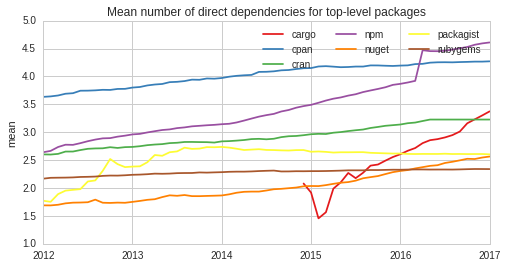

In [31]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df_out.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='mean', 
    title='Mean number of direct dependencies for top-level packages',
)
ax.legend(ncol=len(ECOSYSTEMS) //2 )

savefig(figure, 'graph_toplevel_mean_direct')

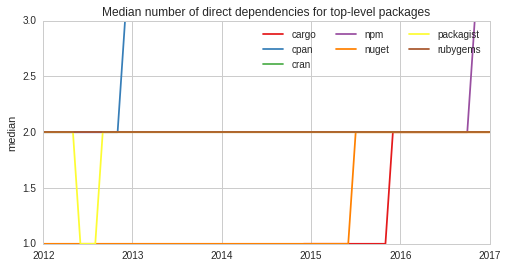

In [32]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df2_out.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='median', 
    title='Median number of direct dependencies for top-level packages',
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_toplevel_median_direct')

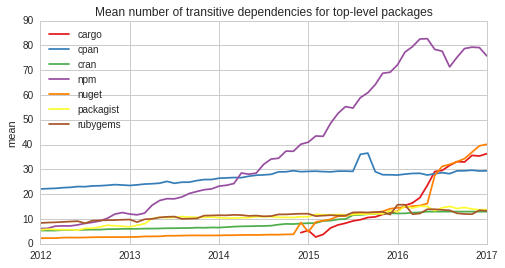

In [33]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df_trout.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='mean', 
    title='Mean number of transitive dependencies for top-level packages',
)

savefig(figure, 'graph_toplevel_mean_transitive')

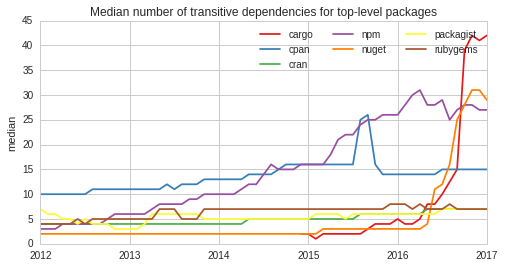

In [34]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df2_trout.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='median', 
    title='Median number of transitive dependencies for top-level packages',
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_toplevel_median_transitive')

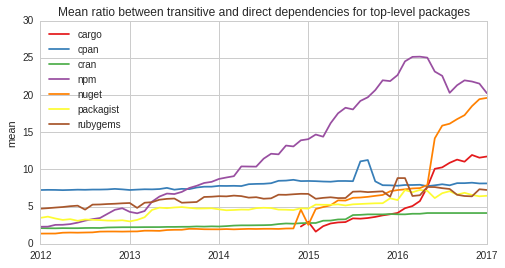

In [35]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df_ratio.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='mean', 
    title='Mean ratio between transitive and direct dependencies for top-level packages',
)

savefig(figure, 'graph_toplevel_mean_ratio')

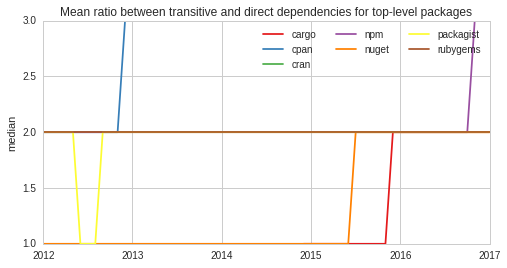

In [36]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df2_out.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='median', 
    title='Mean ratio between transitive and direct dependencies for top-level packages',
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_toplevel_median_ratio')

In [9]:
date = DATE_RANGE[-1]

data = []
for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    vs = graph.vs.select(in_eq=0, out_gt=0)
    data.extend(zip(
        itertools.repeat(ecosystem), 
        vs['out'],
        vs['tr-out']
    ))
            
df = (
    pandas.DataFrame.from_records(data, columns=['ecosystem', 'out', 'tr-out'])
    .assign(ratio=lambda d: d['tr-out'] / d['out'])
    .pipe(lambda d: pandas.melt(d, id_vars='ecosystem', value_vars=['out', 'tr-out', 'ratio'], var_name='kind'))
)

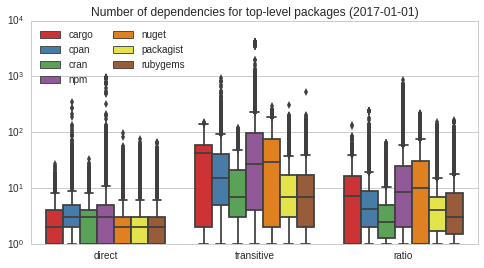

In [11]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

seaborn.boxplot(
    x='kind', 
    y='value', 
    hue='ecosystem',
    data=df,
    ax=ax,
    order=['out', 'tr-out', 'ratio'],
    hue_order=ECOSYSTEMS,
    palette=COLORS,
)

ax.set(
    xlabel='', 
    ylabel='',
    yscale='log',
    title='Number of dependencies for top-level packages ({})'.format(date.strftime('%Y-%m-%d')),
)

ax.set_xticklabels(['direct', 'transitive', 'ratio'])
ax.legend(loc='upper left', ncol=2)

savefig(figure, 'graph_toplevel_distribution_dependencies')

In [15]:
fig = figure

p_title = figure.suptitle
if len(fig.axes) == 1:
    a_title = fig.axes[0].get_title()
    fig.axes[0].set_title('')

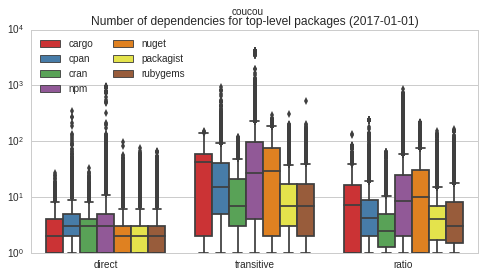

In [20]:
figure.suptitle('coucou')
figure

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


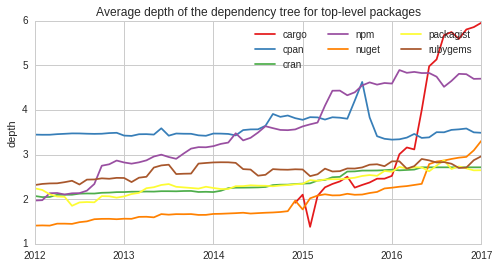

In [39]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        data = []
        for node in graph.vs.select(in_eq=0, out_gt=0):
            m = max((d for v, d, p in graph.bfsiter(node, advanced=True)))
            data.append(m)
        df.loc[date, ecosystem] = pandas.np.mean(data)
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='depth', 
    title='Average depth of the dependency tree for top-level packages',
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_toplevel_mean_depth')

In [4]:
date = DATE_RANGE[-1]

bins = [1, 2, 3, 4, 5, 6, pandas.np.inf]
labels = ['1', '2', '3', '4', '5', '6 or more']

data = []
for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    for node in graph.vs.select(in_eq=0, out_gt=0): 
        depths = []
        for v, d, p in graph.bfsiter(node, advanced=True):
            depths.append(d)
        
        d_max = max(depths)
        d_mean = pandas.np.mean(depths)
        d_median = pandas.np.median(depths)
        
        d_count = collections.Counter(
            pandas.cut(depths, bins=bins, labels=labels, right=False, include_lowest=True)
        )
        
        data.append([ecosystem, d_max, d_mean, d_median] + [d_count[v] for v in labels])

In [5]:
df = pandas.melt(
    pandas.DataFrame.from_records(data, columns=['ecosystem', 'depth', 'mean', 'median'] + labels),
    id_vars='ecosystem',
    value_vars=['depth', 'mean', 'median'] + labels
)

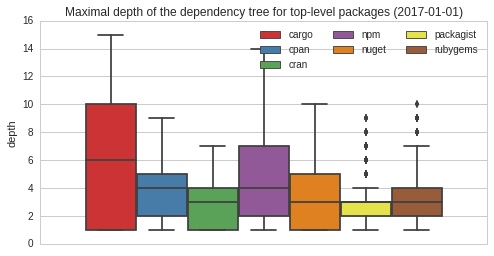

In [42]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

seaborn.boxplot(
    x='_', 
    y='value', 
    hue='ecosystem',
    data=df.query('variable == "depth"').assign(_=1),
    ax=ax,
    hue_order=ECOSYSTEMS,
    palette=COLORS,
)

ax.set(
    xlabel='', 
    ylabel='depth',
    title='Maximal depth of the dependency tree for top-level packages ({})'.format(date.strftime('%Y-%m-%d')),
)

ax.set_xticklabels([''])
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_toplevel_distribution_depth')

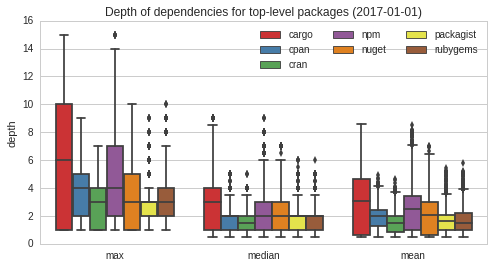

In [43]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

seaborn.boxplot(
    x='variable', 
    y='value', 
    hue='ecosystem',
    data=df.query('variable == "depth" or variable == "median" or variable == "mean"'),
    order=['depth', 'median', 'mean'],
    ax=ax,
    hue_order=ECOSYSTEMS,
    palette=COLORS,
)

ax.set(
    xlabel='', 
    ylabel='depth',
    title='Depth of dependencies for top-level packages ({})'.format(date.strftime('%Y-%m-%d')),
)

ax.set_xticklabels(['max', 'median', 'mean'])
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_toplevel_depth_max_median_mean')

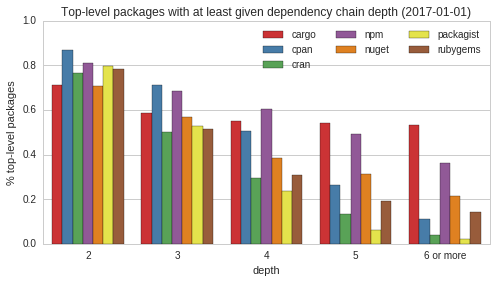

In [6]:
# Proportion of packages with at least one dependency at given depth

df_tmp = (
    df
    .query('variable != "depth" and variable != "mean" and variable != "median" and value > 0')
    .groupby(['ecosystem', 'variable'])
    .count()
    .pipe(lambda d: 
        d.apply(lambda r: r / d.loc[(r.name[0], '1'), 'value'], axis=1)
    )
)


figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

seaborn.barplot(
    x='variable', 
    y='value', 
    hue='ecosystem',
    data=df_tmp.reset_index(),
    ax=ax,
    order=labels[1:],
    hue_order=ECOSYSTEMS,
    palette=COLORS,
)

ax.set(
    xlabel='depth', 
    ylabel='% top-level packages',
    title='Top-level packages with at least given dependency chain depth ({})'.format(date.strftime('%Y-%m-%d')),
    ylim=(0, 1),
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_toplevel_proportion_at_least_depth')

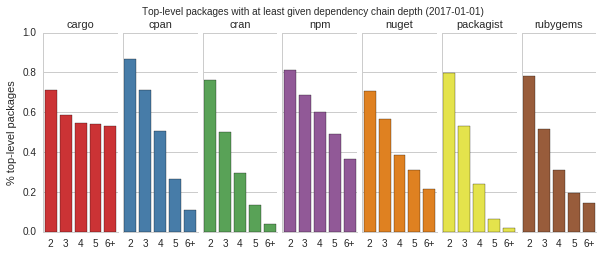

In [10]:
# Proportion of packages with at least one dependency at given depth

df_tmp = (
    df
    .query('variable != "depth" and variable != "mean" and variable != "median" and value > 0')
    .groupby(['ecosystem', 'variable'])
    .count()
    .pipe(lambda d: 
        d.apply(lambda r: r / d.loc[(r.name[0], '1'), 'value'], axis=1)
    )
)

grid = (
    seaborn.FacetGrid(
        data=df_tmp.reset_index(),
        col='ecosystem',
        hue='ecosystem',
        hue_order=ECOSYSTEMS, 
        palette=COLORS,
        ylim=(0, 1),
    )
    .map(seaborn.barplot, 'variable', 'value', order=labels[1:])
    .set_titles('{col_name}')
    .set_axis_labels('', '% top-level packages')
    .set_xticklabels(['2', '3', '4', '5', '6+'])
)
grid.fig.set_size_inches(FIG_SIZE)
grid.fig.suptitle('Top-level packages with at least given dependency chain depth ({})'.format(date.strftime('%Y-%m-%d')))

savefig(grid.fig, 'graph_toplevel_proportion_at_least_depth_b')

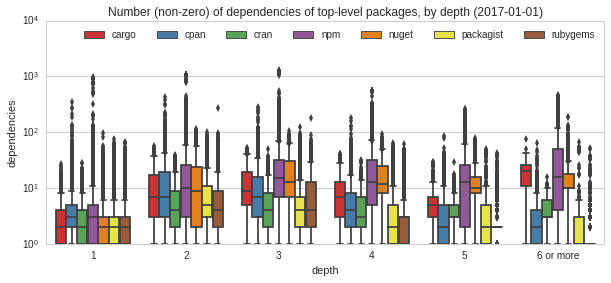

In [45]:
# Number of dependencies by dependency depth

figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE_WIDE)

seaborn.boxplot(
    x='variable', 
    y='value', 
    hue='ecosystem',
    data=df.query('variable != "depth" and variable != "mean" and variable != "median" and value > 0'),
    ax=ax,
    order=labels,
    hue_order=ECOSYSTEMS,
    palette=COLORS,
)

ax.set(
    xlabel='depth', 
    ylabel='dependencies',
    yscale='log',
    title='Number (non-zero) of dependencies of top-level packages, by depth ({})'.format(date.strftime('%Y-%m-%d')),
)    
ax.legend(ncol=len(ECOSYSTEMS))

savefig(figure, 'graph_toplevel_distribution_deps_by_depth')

**TODO**: Which depth should be reached, for a package, to get at least (at most?) x% of all dependencies of this package?

## Relative impact

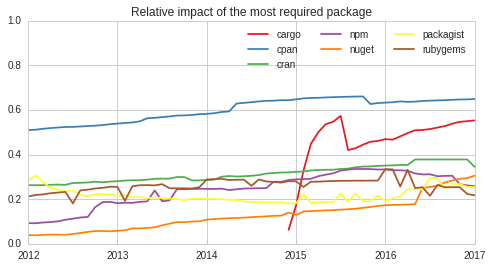

In [38]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = max(graph.vs['tr-in']) / graph.vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Relative impact of the most required package',
    ylim=(0, 1),
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_most_required_relative_impact')

In [39]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.391517,0.83004,0.947667,0.799694,0.899211,0.000383872,0.173556
lin-log,0.302703,0.831217,0.959863,0.744761,0.965881,7.46614e-05,0.17135
log-lin,0.760668,0.631587,0.532319,0.690658,0.472202,0.127544,0.266698
log-log,0.836681,0.647818,0.56447,0.759394,0.665951,0.126227,0.275531


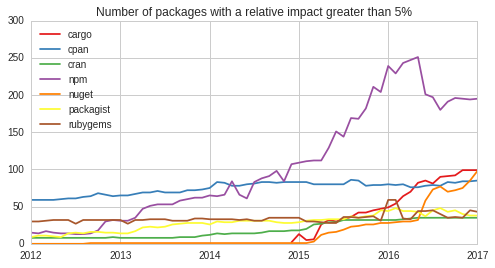

In [47]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

threshold = 5

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        p_threshold = graph.vcount() * threshold / 100
        df.loc[date, ecosystem] = len(graph.vs.select(**{'tr-in_ge': p_threshold}))
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Number of packages with a relative impact greater than {0}%'.format(threshold),
)

savefig(figure, 'graph_relative_impact_{}'.format(threshold))

In [48]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.973528,0.725461,0.897273,0.89283,0.617391,0.90709,0.304278
lin-log,0.746287,0.728448,0.923919,0.924193,0.698875,0.856321,0.337933
log-lin,0.600521,0.639334,0.418795,0.468436,0.214385,0.631877,0.141464
log-log,0.849212,0.664971,0.475283,0.663455,0.69442,0.745094,0.162835


## Reusability metrics

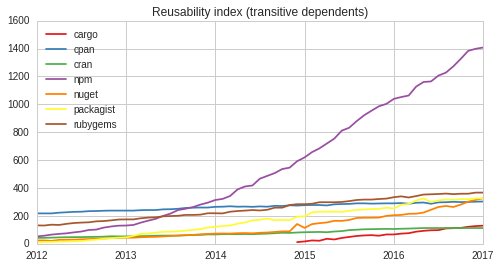

In [49]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = x_index(graph.vs['tr-in'])
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Reusability index (transitive dependents)',
)

savefig(figure, 'graph_reusability_index_transitive')

In [50]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.989197,0.973191,0.971903,0.955181,0.90895,0.990017,0.993473
lin-log,0.900148,0.962051,0.985167,0.974458,0.987128,0.878079,0.980165
log-lin,0.60384,0.688902,0.553274,0.475267,0.431726,0.583085,0.609436
log-log,0.816733,0.713609,0.64014,0.709925,0.638921,0.800793,0.691127


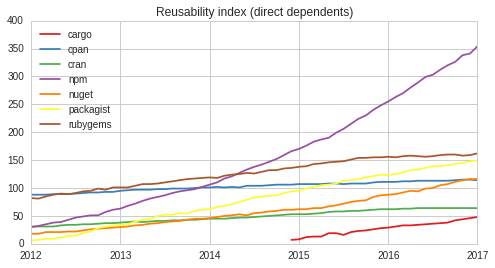

In [51]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = x_index(graph.vs['in'])
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Reusability index (direct dependents)',
)

savefig(figure, 'graph_reusability_index_direct')

In [52]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.984957,0.980056,0.988005,0.966103,0.972557,0.997326,0.982386
lin-log,0.902583,0.970682,0.97917,0.983875,0.985466,0.84757,0.965282
log-lin,0.634115,0.679675,0.619523,0.508944,0.535562,0.634427,0.660917
log-log,0.801125,0.698741,0.679896,0.715597,0.698701,0.844272,0.715221


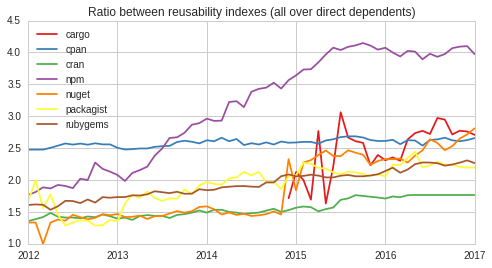

In [53]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = x_index(graph.vs['tr-in']) / x_index(graph.vs['in'])
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Ratio between reusability indexes (all over direct dependents)',
)

savefig(figure, 'graph_reusability_index_ratio')

## Reusability score

In [54]:
# score = sum(1/d) for all n in "tr in", where d is the distance

# NOT MEMORY EFFICIENT!
# graph = graphs['cran'][DATE_RANGE[-1]]
# paths = graph.shortest_paths(mode=igraph.IN)

graph = graphs['cran'][DATE_RANGE[-1]]

for i, node in enumerate(graph.vs):
    score = sum(1/d for d in graph.shortest_paths(source=node.index, mode=igraph.IN)[0] if d > 0)
    node['r-score'] = score

for node in graph.vs:
    if node['r-score'] > 250:
        print('{}: {}'.format(node['name'], node['r-score']))